In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
#%pip install xgboost
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt


# Cargar los datos
data = pd.read_csv("../data.csv")

In [3]:
data = data.drop(columns=['Initial_EDSS', 'Final_EDSS', "Unnamed: 0"])
data = data.dropna()
data

,Gender,Age,Schooling,Breastfeeding,Varicella,Initial_Symptom,Mono_or_Polysymptomatic,Oligoclonal_Bands,LLSSEP,ULSSEP,VEP,BAEP,Periventricular_MRI,Cortical_MRI,Infratentorial_MRI,Spinal_Cord_MRI,group
0,1,34,20.0,1,1,2.0,1,0,1,1,0,0,0,1,0,1,1
1,1,61,25.0,3,2,10.0,2,1,1,0,1,0,0,0,0,1,1
2,1,22,20.0,3,1,3.0,1,1,0,0,0,0,0,1,0,0,1
3,2,41,15.0,1,1,7.0,2,1,0,1,1,0,1,1,0,0,1
4,2,34,20.0,2,1,6.0,2,0,1,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,2,31,8.0,3,1,9.0,2,0,0,0,0,0,0,0,0,0,2
269,1,21,15.0,3,3,5.0,2,1,0,0,0,0,0,0,0,1,2
270,2,19,12.0,3,3,13.0,2,0,1,1,1,0,0,0,0,1,2
271,2,32,15.0,3,3,15.0,2,1,1,1,1,0,1,1,1,0,2


In [4]:
X = data.drop("group", axis=1)
y = data["group"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir KFold para la validación cruzada
kfold = KFold(n_splits=6, shuffle=True, random_state=42)

# Crear el modelo base
model = XGBClassifier()


In [5]:
# Transformar las etiquetas de y_train y y_test
y_train = y_train - 1
y_test = y_test - 1

In [6]:
from sklearn.model_selection import RandomizedSearchCV

In [7]:
#  Definir la grilla de hiperparámetros
param_grid = {
    'max_depth': np.arange(3, 20),  
    'learning_rate': np.linspace(0.001, 0.5, 20),  
    'n_estimators': np.arange(50, 501, 50),  
    'min_child_weight': np.arange(1, 11),
    'gamma': np.linspace(0, 1, 20),  
    'subsample': np.linspace(0.5, 1, 10),  
    'colsample_bytree': np.linspace(0.5, 1, 10),  
    'reg_alpha': np.logspace(-4, 2, 10),
    'reg_lambda': np.logspace(-4, 2, 10),  
    'scale_pos_weight': np.logspace(-1, 1, 5)  
}

In [8]:
# Realizar búsqueda aleatoria de hiperparámetros con KFold CV
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, cv=kfold, scoring='roc_auc', n_iter=2500)
random_search.fit(X_train, y_train)
best_params = random_search.best_params_
print("Mejores parámetros encontrados con RandomizedSearchCV:", best_params)

KeyboardInterrupt: 

In [9]:

#  {'subsample': np.float64(0.6666666666666666), 'scale_pos_weight': np.float64(0.31622776601683794), 'reg_lambda': np.float64(0.002154434690031882), 'reg_alpha': np.float64(1.0), 'n_estimators': np.int64(150), 'min_child_weight': np.int64(1), 'max_depth': np.int64(17), 'learning_rate': np.float64(0.28989473684210526), 'gamma': np.float64(0.05263157894736842), 'colsample_bytree': np.float64(1.0)}
# /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
#   _data = np.array(data, dtype=dtype, copy=copy,

#nueva grilla con los mejores hiperparameteos encontrados
best_params = { 'subsample': 0.6666666666666666, 
  'scale_pos_weight': 0.31622776601683794, 
  'reg_lambda': 0.002154434690031882, 
  'reg_alpha': 1.0, 
  'n_estimators': 150, 
  'min_child_weight': 1, 
  'max_depth': 17, 
  'learning_rate': 0.28989473684210526, 
  'gamma': 0.05263157894736842, 
  'colsample_bytree': 1.0}




Resultados del modelo optimizado:
Accuracy: 87.27%
Recall: 82.14%
F1: 86.79%
AUC: 87.37%


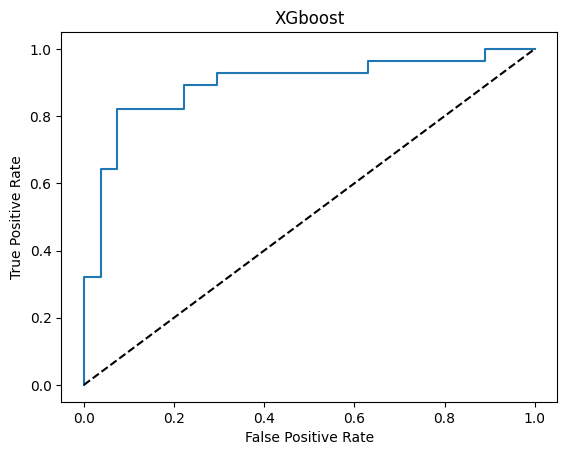

In [19]:
# Entrenar el modelo final con los mejores hiperparámetros 
from sklearn.metrics import roc_curve, auc

opt_model = XGBClassifier(**best_params)
opt_model.fit(X_train, y_train)

import pickle
with open('opt_modelo.pkl','wb') as f:
    pickle.dump(opt_model, f)

# Evaluar el opt_modelo y registrar métricas
y_pred = opt_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred) 
auc = roc_auc_score(y_test, y_pred)

#printear resultados:
print("Resultados del modelo optimizado:")


print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))
print("F1: %.2f%%" % (f1 * 100.0))
print("AUC: %.2f%%" % (auc * 100.0))


# Registrar la curva ROC
y_prob = opt_model.predict_proba(X_test)[:, 1] #lo que predijo con los hiperparametros
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGboost')
plt.show()

In [11]:
# Calcular la importancia de las características y ordenarlas de mayor a menor importancia 
importance_df = pd.DataFrame({'feature': X.columns, 'importance': opt_model.feature_importances_})
importance_df = importance_df.sort_values('importance', ascending=False) 
#imprimir las features importasnces
print(importance_df)

# # Guardar el modelo
# import joblib
# joblib.dump(model, 'model.joblib')
# joblib.dump(importance_df, 'importance_df.joblib')

# # Guardar los datos de importancia de características
# importance_df.to_csv('importance_df.csv', index=False)

                    feature  importance
12      Periventricular_MRI    0.230760
14       Infratentorial_MRI    0.123655
0                    Gender    0.087368
2                 Schooling    0.074255
15          Spinal_Cord_MRI    0.072421
13             Cortical_MRI    0.066456
5           Initial_Symptom    0.066095
7         Oligoclonal_Bands    0.050886
6   Mono_or_Polysymptomatic    0.049057
8                    LLSSEP    0.036455
3             Breastfeeding    0.035934
1                       Age    0.034845
10                      VEP    0.026582
9                    ULSSEP    0.023857
4                 Varicella    0.021374
11                     BAEP    0.000000


In [12]:
#cantidad de train y test

cant_train = X_train.shape
cant_test = X_test.shape
print("Cantidad de datos de TRAIN: ", cant_train)
print("Cantidad de datos de TEST: ", cant_test)

Cantidad de datos de TRAIN:  (216, 16)
Cantidad de datos de TEST:  (55, 16)


In [13]:
#Distribución de la variable objetivo (tanto % positivos tantos negativos)
distribucion = y.value_counts()
print("Distribución de la variable objetivo: ", distribucion)

Distribución de la variable objetivo:  group
2    146
1    125
Name: count, dtype: int64


In [14]:
# #antes yo borre las columnas Initial_EDSS', 'Final_EDSS', "Unnamed: 0 del datasert para la predicion. ahora quiero recuperarlas para ver procentajes de datos, etc
# data = pd.read_csv("../data.csv")
# data = data.dropna()
# print("Cantidad de datos de dataset original: ", data.shape)
# print("Distribución de la variable objetivo: ", data['group'].value_counts())


In [15]:
#Distribución de la variable objetivo (tanto % positivos tantos negativos)
distribucion = y.value_counts(normalize=True)
print("Distribución de la variable objetivo: ", distribucion)

Distribución de la variable objetivo:  group
2    0.538745
1    0.461255
Name: proportion, dtype: float64


In [16]:
#Tipos de los datos
tipos = data.dtypes
tipos


Gender                       int64
Age                          int64
Schooling                  float64
Breastfeeding                int64
Varicella                    int64
Initial_Symptom            float64
Mono_or_Polysymptomatic      int64
Oligoclonal_Bands            int64
LLSSEP                       int64
ULSSEP                       int64
VEP                          int64
BAEP                         int64
Periventricular_MRI          int64
Cortical_MRI                 int64
Infratentorial_MRI           int64
Spinal_Cord_MRI              int64
group                        int64
dtype: object